# Visualise data distribution

- audio durations?
- imbalance classes?

# Prepare ENV/Load libraries

## Mount Google Drive

In [1]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# change directory to the project path

project_path = os.path.join(google_drive_path, "Colab Notebooks/SER/")
os.chdir(project_path)
os.listdir("./")

['utils',
 'fonts',
 'meta_data',
 'dataset',
 '.git',
 '.env',
 'libs',
 'README.md',
 'models',
 'logs',
 'Data distribution.ipynb',
 'Experiment Preprocessing.ipynb',
 'Notebook Template Train.ipynb',
 'SER Model idea.drawio',
 'deprecated',
 'Preprocess Json to CSV.ipynb',
 'Notebook Template.ipynb',
 'Untitled0.ipynb',
 'Train Multi-layer Transformer.ipynb',
 'tmp',
 '.gitignore']

## Install libraries

In [3]:
# !rm -rf tmp && git clone https://github.com/chuan-khuna/my-python-utils.git tmp && cp -R tmp/utils ./ && cp -R tmp/fonts ./ && rm -rf tmp

In [4]:
!python3 --version

Python 3.8.16


Install latest tensorflow version

In [5]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
     |████████████████████████████████| 1.1 MB 16.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf2onnx 1.13.0 requires flatbuffers<3.0,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
onnx 1.13.0 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.


In [6]:
!pip install matplotlib seaborn -Uq
!pip install pythainlp -q
!pip install keras-tuner -q
!pip install pyYAML -q
!pip install tensorflow-io[tensorflow] tf2onnx onnxruntime -Uq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.0 which is incompatible.


In [7]:
%load_ext tensorboard

# Import Libraries

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patheffects
import seaborn as sns

import json
import yaml
import re
from tqdm.notebook import trange, tqdm

import datetime

import tf2onnx
import onnx
import onnxruntime as rt

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner
import tensorflow_io as tfio

seed_ = 20200218
tf.random.set_seed(seed_)
np.random.seed(seed_)

from sklearn.metrics import confusion_matrix, classification_report

In [10]:
from utils.vis_utils import *

font_dir = [f"{google_drive_path}/code_assets/fonts/"]
mpl_import_fonts(font_dir)

## Ensure that matplotlib can use subplot mosaic

In [11]:
def check_version(version_str, major, minor):
    print(version_str)
    version = [int(i) for i in version_str.split('.')]
    assert version[0] >= major and version[1] >= minor

check_version(matplotlib.__version__, 3, 6)
check_version(sns.__version__, 0, 12)

del check_version

matplotlib.__version__, sns.__version__, tf.__version__

3.6.2
0.12.2


('3.6.2', '0.12.2', '2.9.0')

## View hardware spec

In [12]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [13]:
tf.config.list_physical_devices('GPU')

for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

In [14]:
def get_timestamp():
    return datetime.datetime.strftime(datetime.datetime.now(), "%Y%m%d-%H%M")

get_timestamp()

'20230102-1322'

# Load DataFrame

In [15]:
df = pd.read_csv("./meta_data/dataset.csv")

In [16]:
df

,path,file,assigned_emo,majority_emo,agreement,duration
0,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor025_impro4_7.flac,Angry,Angry,0.642857,4.780
1,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor025_impro4_15.flac,Angry,Frustrated,0.857143,0.807
2,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor025_impro2_24.flac,Happy,Happy,0.857143,3.752
3,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor026_impro4_16.flac,Frustrated,Frustrated,0.750000,1.832
4,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor025_script3_2_4b.flac,Sad,Sad,1.000000,7.492
...,...,...,...,...,...,...
27849,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor090_script2_1_4a.flac,Sad,Sad,0.900000,8.854
27850,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor089_script1_1_1a.flac,Neutral,Neutral,0.600000,4.416
27851,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor090_impro7_9.flac,Frustrated,None,0.000000,1.085
27852,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor089_impro10_9.flac,Angry,Frustrated,0.800000,3.404


# Clean Dataframe

## corrupted files are marked duration as -1

In [17]:
df[df['duration'] <= 0]

,path,file,assigned_emo,majority_emo,agreement,duration


In [18]:
df['majority_emo'].drop_duplicates()

0            Angry
1       Frustrated
2            Happy
4              Sad
9          Neutral
19            None
8401         other
Name: majority_emo, dtype: object

In [19]:
emo_labels = ['Frustrated', 'Neutral', 'Happy', 'Sad', 'Angry']

In [20]:
df = df[df['duration'] > 0]
df = df[df['majority_emo'].isin(emo_labels)]
df = df.reset_index(drop=True)
df

,path,file,assigned_emo,majority_emo,agreement,duration
0,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor025_impro4_7.flac,Angry,Angry,0.642857,4.780
1,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor025_impro4_15.flac,Angry,Frustrated,0.857143,0.807
2,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor025_impro2_24.flac,Happy,Happy,0.857143,3.752
3,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor026_impro4_16.flac,Frustrated,Frustrated,0.750000,1.832
4,/content/dataset/studio11-20/studio013/con/s01...,s013_con_actor025_script3_2_4b.flac,Sad,Sad,1.000000,7.492
...,...,...,...,...,...,...
25180,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor089_impro6_1.flac,Happy,Happy,0.600000,0.693
25181,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor090_script2_1_4a.flac,Sad,Sad,0.900000,8.854
25182,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor089_script1_1_1a.flac,Neutral,Neutral,0.600000,4.416
25183,/content/dataset/studio21-30/studio025/con/s02...,s025_con_actor089_impro10_9.flac,Angry,Frustrated,0.800000,3.404


# Visualisation

In [21]:
df['duration'].describe()

count    25185.000000
mean         5.383580
std          4.068824
min          0.288000
25%          3.230000
50%          4.659000
75%          6.476000
max        108.788000
Name: duration, dtype: float64

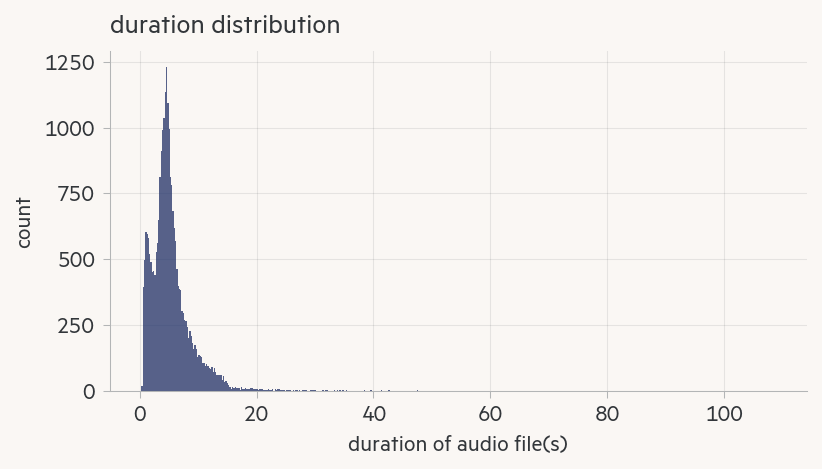

In [22]:
fig = plt.figure(figsize=(6, 3), dpi=150)
sns.histplot(df['duration'])

plt.title(f"duration distribution")
plt.xlabel('duration of audio file(s)')
plt.ylabel('count')

plt.show()

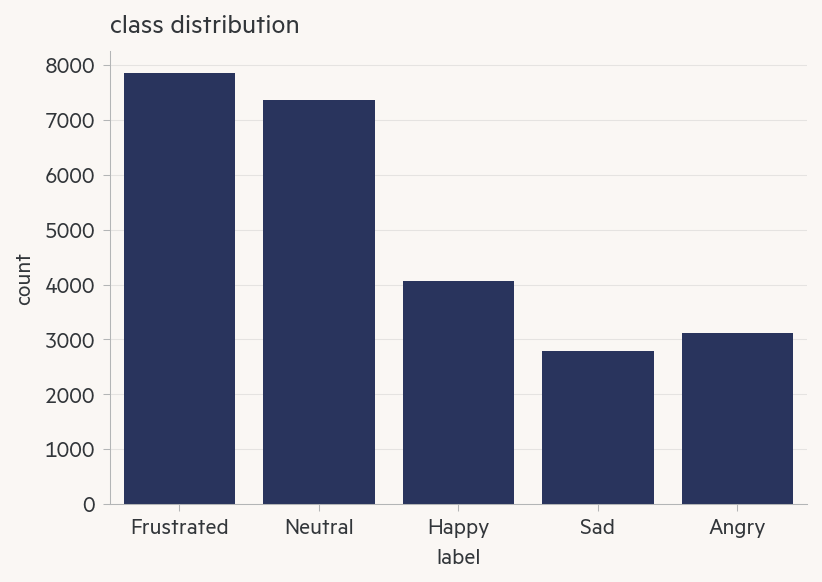

In [23]:
value_count = df['majority_emo'].value_counts()[emo_labels]

fig = plt.figure(figsize=(6, 4), dpi=150)
sns.barplot(x=value_count.index, y=value_count, color='#202f66')

plt.title(f"class distribution")
plt.xlabel('label')
plt.ylabel('count')

plt.show()

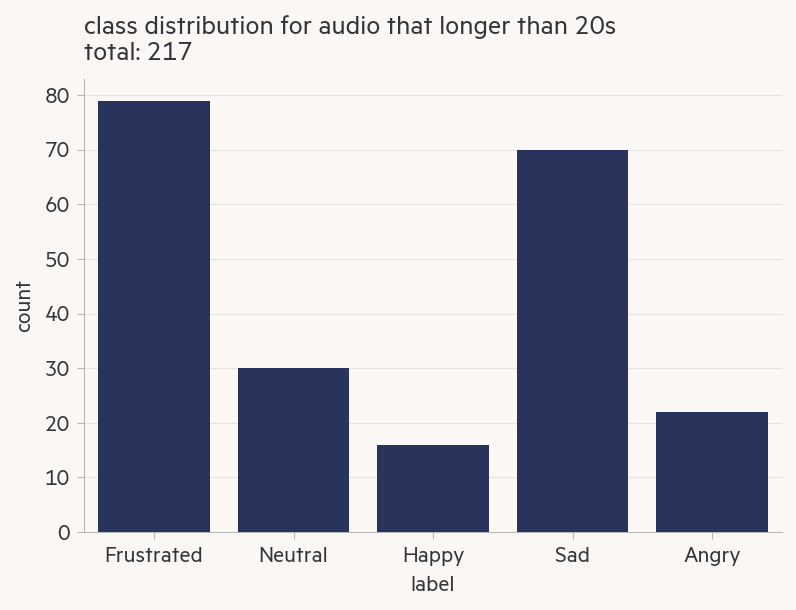

In [24]:
duration_thres = 20
value_count = df[df['duration'] > duration_thres]['majority_emo'].value_counts()[emo_labels]

fig = plt.figure(figsize=(6, 4), dpi=150)
sns.barplot(x=value_count.index, y=value_count, color='#202f66')

plt.title(f"class distribution for audio that longer than {duration_thres}s\ntotal: {value_count.sum()}")
plt.xlabel('label')
plt.ylabel('count')

plt.show()

In [25]:
df[df['duration'] > 20].sort_values(by='duration')

,path,file,assigned_emo,majority_emo,agreement,duration
8293,/content/dataset/zoom1-10/zoom003/mic/z003_mic...,z003_mic_actor041_impro3_7.flac,Sad,Sad,1.000000,20.001
531,/content/dataset/studio11-20/studio018/con/s01...,s018_con_actor035_impro5_7.flac,Frustrated,Frustrated,0.750000,20.009
9500,/content/dataset/zoom1-10/zoom007/mic/z007_mic...,z007_mic_actor050_impro4_12.flac,Frustrated,Frustrated,1.000000,20.015
9990,/content/dataset/zoom1-10/zoom008/mic/z008_mic...,z008_mic_actor051_impro3_8.flac,Sad,Sad,0.900000,20.078
8496,/content/dataset/zoom1-10/zoom002/mic/z002_mic...,z002_mic_actor039_impro1_8.flac,Neutral,Neutral,0.750000,20.085
...,...,...,...,...,...,...
24843,/content/dataset/studio21-30/studio030/con/s03...,s030_con_actor100_impro10_12.flac,Angry,Angry,1.000000,86.473
447,/content/dataset/studio11-20/studio018/con/s01...,s018_con_actor035_impro3_5.flac,Sad,Sad,0.854167,88.917
12784,/content/dataset/zoom11-20/zoom019/mic/z019_mi...,z019_mic_actor073_impro1_16.flac,Neutral,Angry,0.800000,91.016
7757,/content/dataset/zoom1-10/zoom009/mic/z009_mic...,z009_mic_actor053_script3_2_4a.flac,Sad,Frustrated,0.566667,91.245


In [26]:
df[df['duration'] > 30].sort_values(by='duration')

,path,file,assigned_emo,majority_emo,agreement,duration
835,/content/dataset/studio11-20/studio012/con/s01...,s012_con_actor023_impro3_5.flac,Sad,Sad,0.857143,30.093
8297,/content/dataset/zoom1-10/zoom003/mic/z003_mic...,z003_mic_actor042_impro3_1.flac,Neutral,Neutral,0.900000,30.178
9612,/content/dataset/zoom1-10/zoom007/mic/z007_mic...,z007_mic_actor050_impro3_7.flac,Neutral,Frustrated,0.625000,30.374
9390,/content/dataset/zoom1-10/zoom001/mic/z001_mic...,z001_mic_actor037_impro3_10.flac,Sad,Sad,0.750000,30.744
10808,/content/dataset/zoom11-20/zoom013/mic/z013_mi...,z013_mic_actor062_impro3_6.flac,Neutral,Neutral,0.600000,31.324
...,...,...,...,...,...,...
24843,/content/dataset/studio21-30/studio030/con/s03...,s030_con_actor100_impro10_12.flac,Angry,Angry,1.000000,86.473
447,/content/dataset/studio11-20/studio018/con/s01...,s018_con_actor035_impro3_5.flac,Sad,Sad,0.854167,88.917
12784,/content/dataset/zoom11-20/zoom019/mic/z019_mi...,z019_mic_actor073_impro1_16.flac,Neutral,Angry,0.800000,91.016
7757,/content/dataset/zoom1-10/zoom009/mic/z009_mic...,z009_mic_actor053_script3_2_4a.flac,Sad,Frustrated,0.566667,91.245


In [27]:
df[df['duration'] > 60].sort_values(by='duration')

,path,file,assigned_emo,majority_emo,agreement,duration
8425,/content/dataset/zoom1-10/zoom003/mic/z003_mic...,z003_mic_actor041_impro2_6.flac,Happy,Happy,1.000000,63.828
2085,/content/dataset/studio11-20/studio015/con/s01...,s015_con_actor029_impro3_4.flac,Sad,Sad,0.500000,64.493
10846,/content/dataset/zoom11-20/zoom020/mic/z020_mi...,z020_mic_actor076_script2_2_4a.flac,Sad,Angry,0.566667,65.585
6259,/content/dataset/studio1-10/studio003/con/s003...,s003_con_actor006_impro3_5.flac,Neutral,Neutral,1.000000,67.008
7399,/content/dataset/studio1-10/studio004/con/s004...,s004_con_actor008_impro5_2.flac,Sad,Sad,0.785714,74.745
24843,/content/dataset/studio21-30/studio030/con/s03...,s030_con_actor100_impro10_12.flac,Angry,Angry,1.000000,86.473
447,/content/dataset/studio11-20/studio018/con/s01...,s018_con_actor035_impro3_5.flac,Sad,Sad,0.854167,88.917
12784,/content/dataset/zoom11-20/zoom019/mic/z019_mi...,z019_mic_actor073_impro1_16.flac,Neutral,Angry,0.800000,91.016
7757,/content/dataset/zoom1-10/zoom009/mic/z009_mic...,z009_mic_actor053_script3_2_4a.flac,Sad,Frustrated,0.566667,91.245
9632,/content/dataset/zoom1-10/zoom007/mic/z007_mic...,z007_mic_actor050_impro4_7.flac,Frustrated,Frustrated,1.000000,108.788


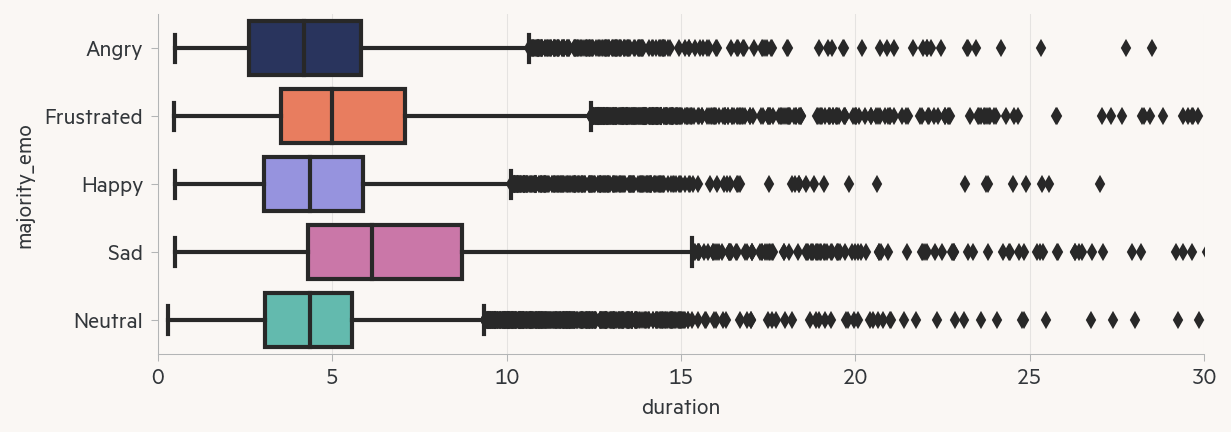

In [35]:
fig = plt.figure(figsize=(9, 3), dpi=150)
sns.boxplot(data=df, y='majority_emo', x='duration')
plt.xlim([0, 30])
plt.show()